In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [36]:
path = os.path.join('boreholes4.csv')
raw_data = pd.read_csv(path)
raw_data.head()

,borehole,chainage,depth,type
0,bh1,0,0.0,fill
1,bh1,0,1.5,fill
2,bh1,0,3.0,HW_breccia
3,bh1,0,4.5,HW_breccia
4,bh1,0,6.0,HW_breccia


In [37]:
# data preprocessing
chainages = raw_data['chainage'].unique()
boreholes = raw_data['borehole'].unique()

other_bhs = boreholes[1:]
frames = [raw_data] 

means = []
for i in range(len(chainages)):
    if (i+1 == len(chainages)):
        break
    else:
        mean = (chainages[i]+chainages[i+1])/2
        means.append(mean)

for index,current_bh in enumerate(other_bhs):
    preprocessing = raw_data[raw_data['borehole']==current_bh].copy()
    preprocessing['borehole'] = current_bh+'_pp'
    preprocessing['chainage'] = means[index]
    
    frames.append(preprocessing)
    
data = pd.concat(frames,axis=0)

In [38]:
soil_types = list(data['type'].unique())
soil_types

['fill', 'HW_breccia', 'MW_breccia', 'SW_breccia', 'clay']

In [39]:
# 1. Seperate the data into dependent and independent variables
X = data.iloc[:,1:3].values
Y = np.array(data.iloc[:,3]).reshape(-1,1)
# 2. then convert the dependent variables into different class usnig onehotencoder class -> beware of the dummy variable trap
# 3. then to choose the classification models

In [40]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y_encode = encoder.fit_transform(Y.ravel())
Y_encode[0:5], encoder.transform(['HW_breccia'])

(array([4, 4, 0, 0, 0]), array([0]))

In [41]:
# modelling using Naive Bayes Classification
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X,Y_encode)

GaussianNB(priors=None, var_smoothing=1e-09)

In [42]:
# prediction
value = classifier.predict(np.array([40,25]).reshape(-1,2))
encoder.inverse_transform(value)
# sorting the soil types as per label value for plotting purpose
sorted_soil_types = list([encoder.inverse_transform([x])[0] for x in range(len(soil_types))])
sorted_soil_types

['HW_breccia', 'MW_breccia', 'SW_breccia', 'clay', 'fill']

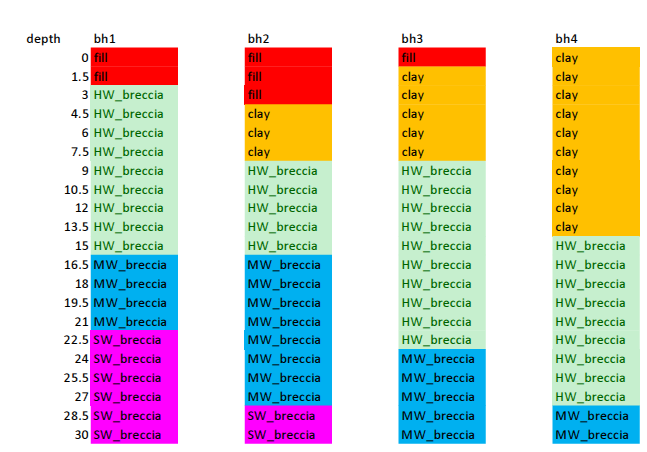

In [43]:
from IPython.display import Image
Image("../input/images/As_built_bh_data.png")

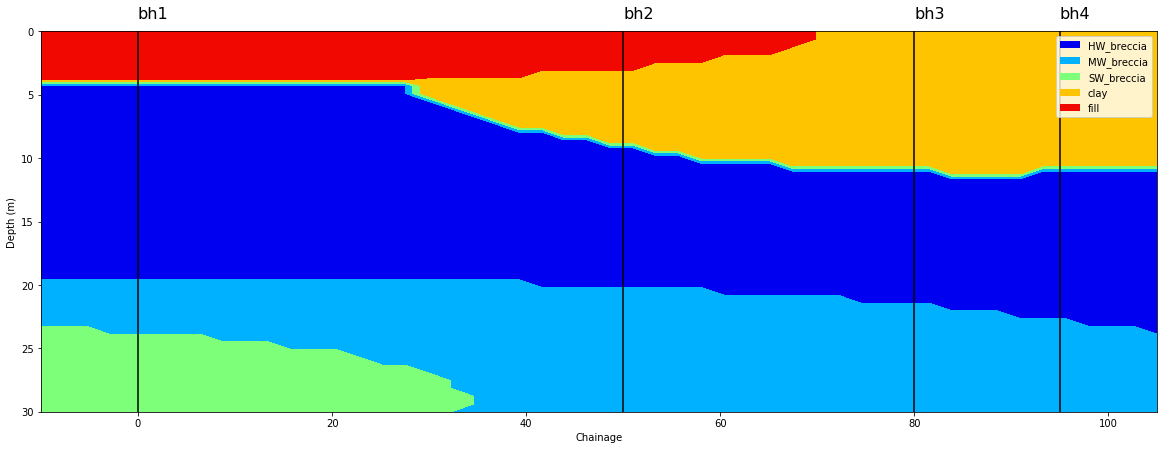

In [44]:
# plotting the classification
from matplotlib.colors import ListedColormap
x1 = np.linspace(min(X[:,0])-10,max(X[:,0])+10,num=50)
x2 = np.linspace(min(X[:,1]),max(X[:,1]),num=50)

n1 = len(x1)
n2 = len(x2)

X1_grid,X2_grid = np.meshgrid(x1,x2) # for plotting
Y_grid = np.zeros((n2,n1))
for i in range(n1):
    for j in range(n2):
        p,v = x1[i],x2[j]
        soil = classifier.predict(np.array([p,v]).reshape(-1,2))
        soil = encoder.inverse_transform(soil)
        Y_grid[j,i] = encoder.transform(soil)
        
        # for debugging the 2D matrix
        #print(soil,p,v,Y_grid[j,i])
        #print('=====')
        #break 

# Plotting the values
fig = plt.figure(figsize=(20,7)) 
ax = fig.add_subplot(111)
contour = ax.contourf(X1_grid,X2_grid,Y_grid,cmap=plt.get_cmap('jet'),levels=[-1,0,1,2,3,4])
proxy = [Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in contour.collections]
ax.legend(proxy, sorted_soil_types)
#ax.legend()
ax.invert_yaxis()
ax.set_xlabel('Chainage')
ax.set_ylabel('Depth (m)')

# plot the borehole locations
for name, group in raw_data.groupby(['borehole','chainage']):
    bh,chainage = name[0],name[1]
    ax.plot([chainage,chainage],[0,30],color='k')
    ax.text(x=chainage,y=-1,s=bh,fontsize=16)

![](http://)